In [56]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
movies = pd.read_csv('movie_industry_clean.csv')

In [57]:
movies.head()

Unnamed: 0  index                                            name rating  \
0           0      0                                     The Shining      R   
1           1      1                                 The Blue Lagoon      R   
2           2      2  Star Wars: Episode V - The Empire Strikes Back     PG   
3           3      3                                       Airplane!     PG   
4           4      4                                      Caddyshack      R   

       genre  year                       released  score      votes  \
0      Drama  1980  June 13, 1980 (United States)    8.4   927000.0   
1  Adventure  1980   July 2, 1980 (United States)    5.8    65000.0   
2     Action  1980  June 20, 1980 (United States)    8.7  1200000.0   
3     Comedy  1980   July 2, 1980 (United States)    7.7   221000.0   
4     Comedy  1980  July 25, 1980 (United States)    7.3   108000.0   

          director                   writer            star         country  \
0  Stanley Kubrick             Stephen King  Jack Nicholson  United Kingdom   
1   Randal Kleiser  Henry De Vere Stacpoole  Brooke Shields   United States   
2   Irvin Kershner           Leigh Brackett     Mark Hamill   United States   
3     Jim Abrahams             Jim Abrahams     Robert Hays   United States   
4     Harold Ramis       Brian Doyle-Murray     Chevy Chase   United States   

       budget        gross             company  runtime  
0  19000000.0   46998772.0        Warner Bros.    146.0  
1   4500000.0   58853106.0   Columbia Pictures    104.0  
2  18000000.0  538375067.0           Lucasfilm    124.0  
3   3500000.0   83453539.0  Paramount Pictures     88.0  
4   6000000.0   39846344.0      Orion Pictures     98.0

In [58]:
# split into training & test
np.random.seed(2)
train = movies.sample(round(movies.shape[0]*0.8)) # 80%
test = movies.drop(train.index)

## INITIAL EDA (incomplete, can be built off of)

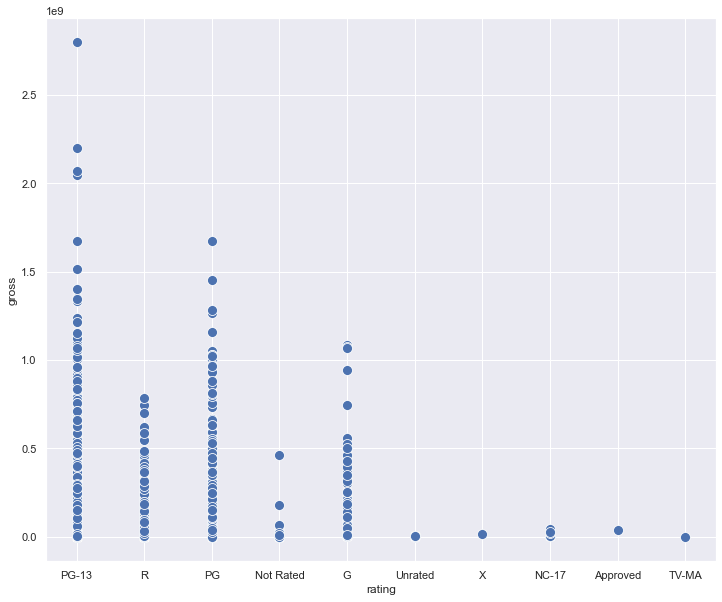

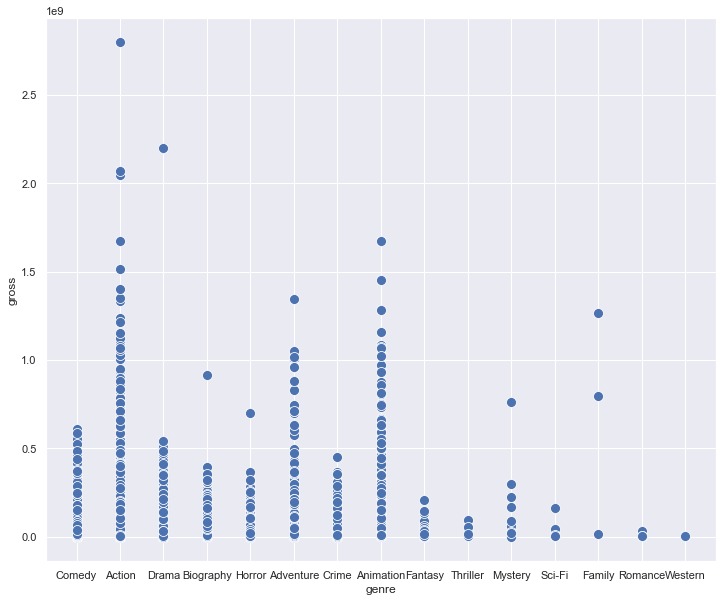

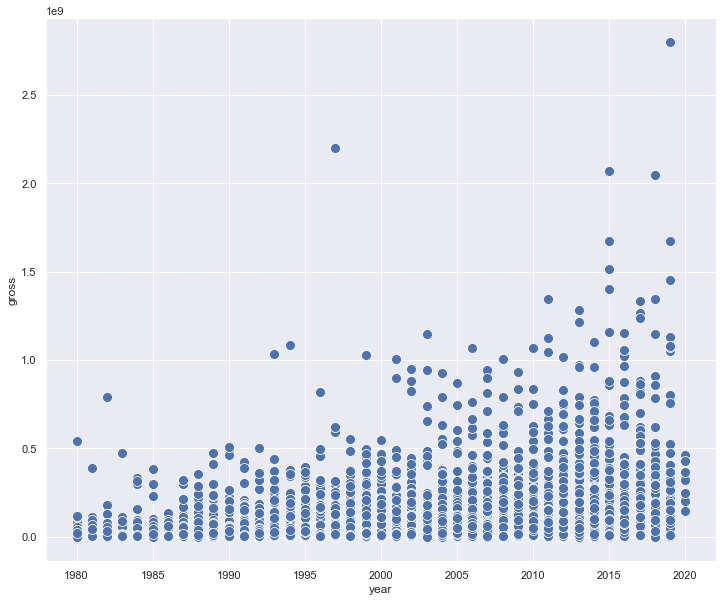

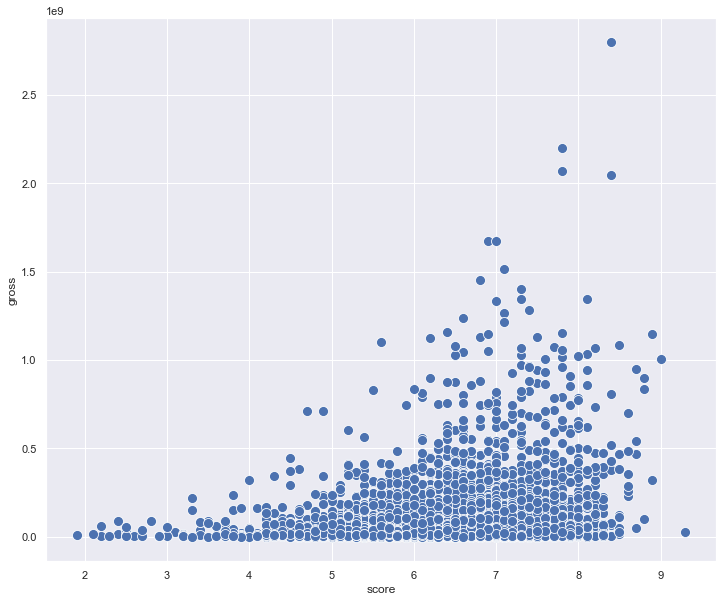

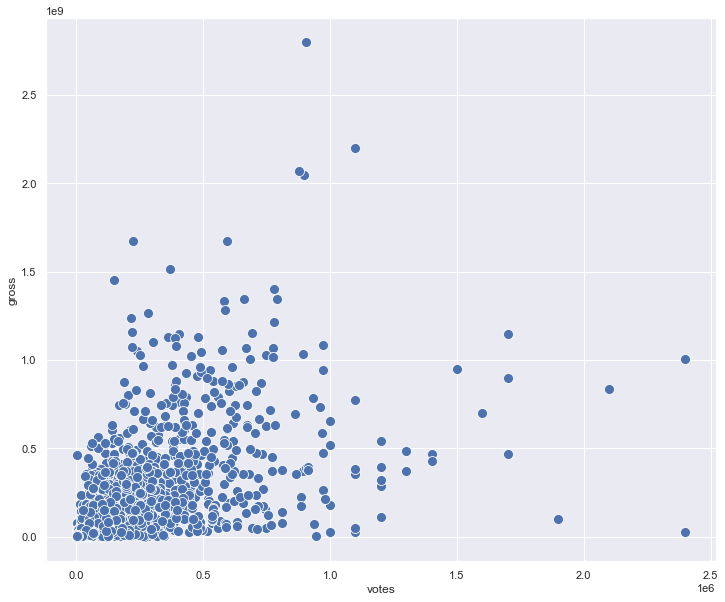

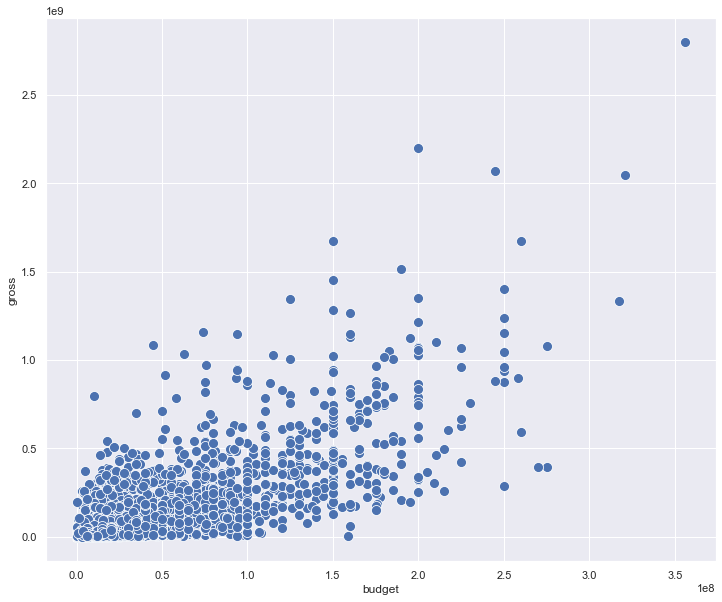

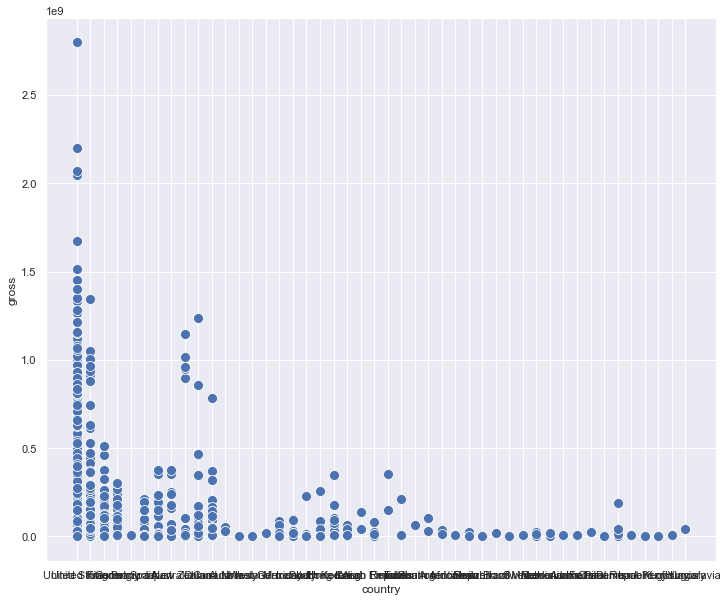

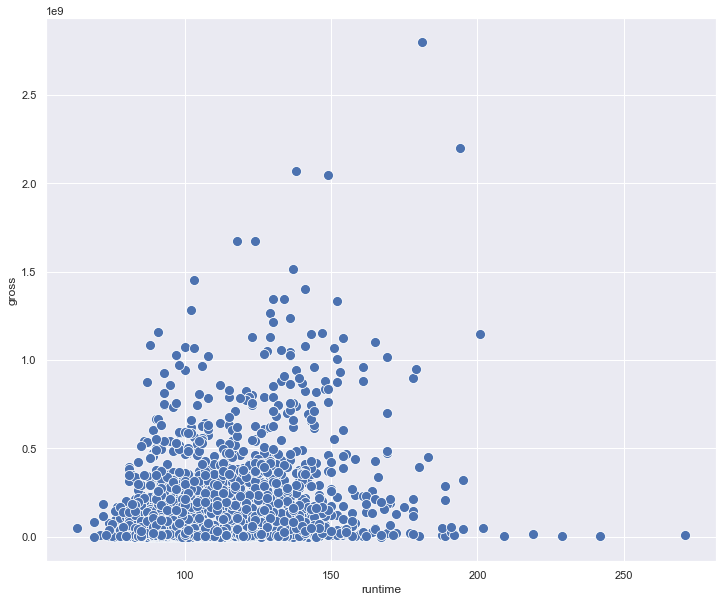

In [60]:
# visualizations of variables
cols = ['rating','genre','year','score','votes','budget','country','runtime']
for col in cols:
    sns.scatterplot(x = col, y = 'gross', data = train)
    plt.show()

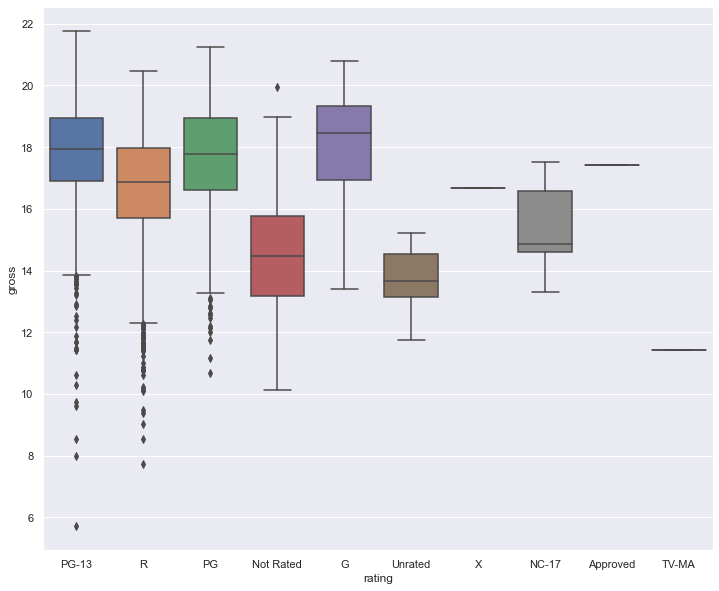

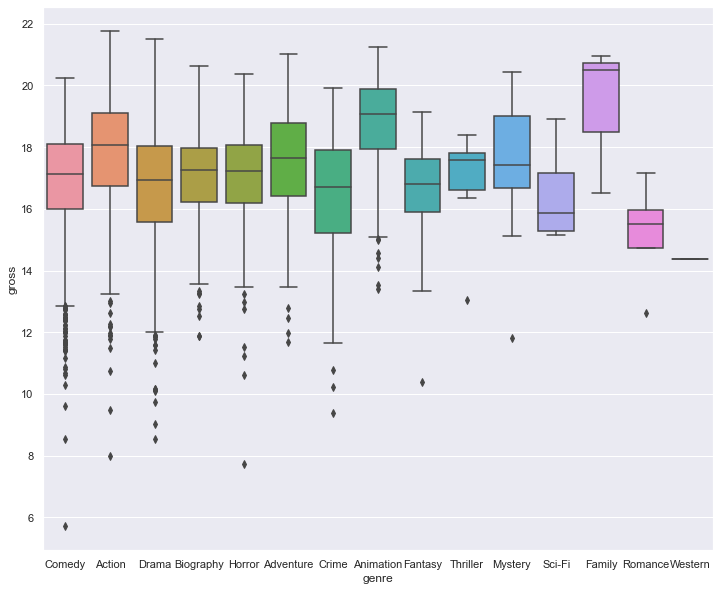

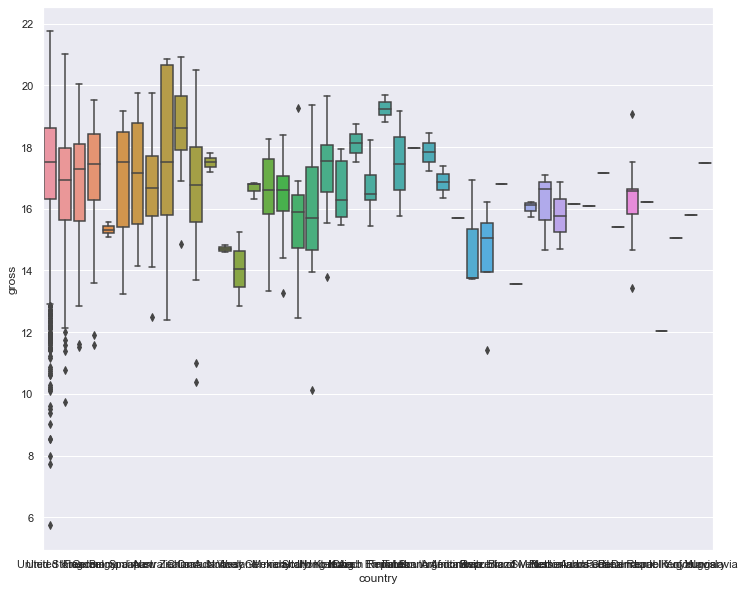

In [62]:
# visualizations of categorical variables vs gross
for col in ['rating','genre','country']:
    sns.boxplot(x = col, y = np.log(train.gross), data = train)
    plt.show()

In [64]:
# the start of a model by hand
ols_object = sm.ols(formula = 'gross~budget', data = train)
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     5391.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        23:38:25   Log-Likelihood:                -86983.
No. Observations:                4337   AIC:                         1.740e+05
Df Residuals:                    4335   BIC:                         1.740e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.681e+07   2.49e+06     -6.749      0.000   -2.17e+07   -1.19e+07
budget         3.3286      0.045     73.426      0.000       3.240       3.417
==============================================================================
Omnibus:                     3308.535   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           143547.435
Skew:                           3.221   Prob(JB):                         0.00
Kurtosis:                      30.438   Cond. No.                     7.26e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.26e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# data wrangling & creating dummy variables
def wrangling(df):
    df = df.drop('Unnamed: 0', axis=1)
    df = df.drop('index', axis=1)
    df.replace(' ', '_', regex=True, inplace = True)
    df.replace('-', '_', regex=True, inplace = True)
    rating_dummy = pd.get_dummies(df['rating'])
    df = pd.concat([df, rating_dummy], axis=1)
    df = df.drop('rating', axis=1)
    genre_dummy = pd.get_dummies(df['genre'])
    df = pd.concat([df, genre_dummy], axis=1)
    df = df.drop('genre', axis=1)
    country_dummy = pd.get_dummies(df['country'])
    df = pd.concat([df, country_dummy], axis=1)
    df = df.drop('country', axis=1)
    return df

In [31]:
train = wrangling(train)
test = wrangling(test)

## MULTICOLLINEARITY CHECK

In [4]:
# doing VIF to see if there is multicollinearity
X = train[['year','score','votes','budget','runtime']]
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

   feature           VIF
0    const  40965.310821
1     year      1.130068
2    score      1.512960
3    votes      1.685885
4   budget      1.499190
5  runtime      1.347823


In [5]:
# There is very little collinearity.

<AxesSubplot:>

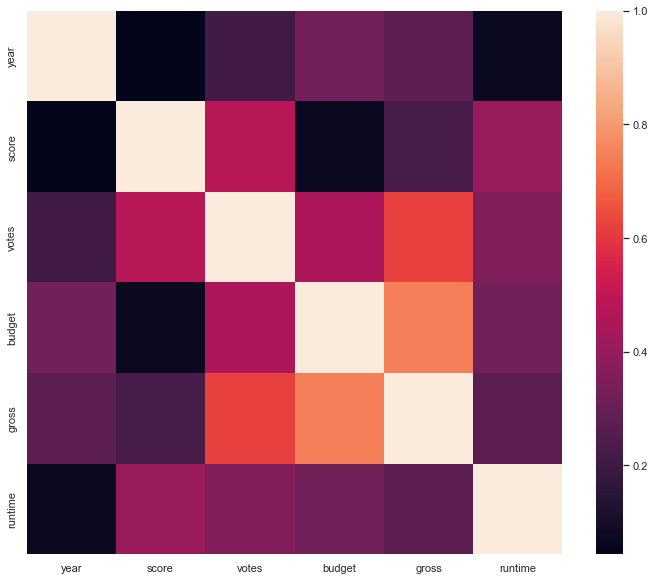

In [6]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(train.corr())

In [8]:
train.rating.unique()

array(['PG_13', 'R', 'PG', 'Not_Rated', 'G', 'Unrated', 'X', 'NC_17',
       'Approved', 'TV_MA'], dtype=object)

In [9]:
train.genre.unique()

array(['Comedy', 'Action', 'Drama', 'Biography', 'Horror', 'Adventure',
       'Crime', 'Animation', 'Fantasy', 'Thriller', 'Mystery', 'Sci_Fi',
       'Family', 'Romance', 'Western'], dtype=object)

In [10]:
train.country.unique()

array(['United_States', 'United_Kingdom', 'France', 'Germany', 'Belgium',
       'Spain', 'Japan', 'Australia', 'New_Zealand', 'China', 'Canada',
       'Austria', 'Norway', 'Iceland', 'West_Germany', 'Mexico',
       'Ireland', 'Italy', 'South_Korea', 'Hong_Kong', 'India',
       'United_Arab_Emirates', 'Czech_Republic', 'Finland', 'Taiwan',
       'Lebanon', 'South_Africa', 'Argentina', 'Indonesia', 'Iran',
       'Switzerland', 'Brazil', 'Republic_of_Macedonia', 'Sweden',
       'Russia', 'Netherlands', 'Aruba', 'Jamaica', 'Chile', 'Panama',
       'Denmark', 'Israel', 'Federal_Republic_of_Yugoslavia', 'Kenya',
       'Yugoslavia', 'Hungary'], dtype=object)

In [12]:
train

name  year  \
3496          I_Now_Pronounce_You_Chuck_&_Larry  2007   
738                                   Dead_Heat  1988   
2826                           American_Wedding  2003   
4048         You_Will_Meet_a_Tall_Dark_Stranger  2010   
727                              Action_Jackson  1988   
...                                         ...   ...   
4916                              Gods_of_Egypt  2016   
4396        The_Hobbit:_The_Desolation_of_Smaug  2013   
1528                          Leaving_Las_Vegas  1995   
4155                                   J._Edgar  2011   
1094  Beastmaster_2:_Through_the_Portal_of_Time  1991   

                               released  score     votes         director  \
3496      July_20,_2007_(United_States)    5.9  143000.0     Dennis_Dugan   
738         May_6,_1988_(United_States)    6.0    7200.0   Mark_Goldblatt   
2826     August_1,_2003_(United_States)    6.3  198000.0      Jesse_Dylan   
4048   October_22,_2010_(United_States)    6.3   44000.0      Woody_Allen   
727   February_12,_1988_(United_States)    5.4   10000.0  Craig_R._Baxley   
...                                 ...    ...       ...              ...   
4916  February_26,_2016_(United_States)    5.4  110000.0      Alex_Proyas   
4396  December_13,_2013_(United_States)    7.8  615000.0    Peter_Jackson   
1528   February_9,_1996_(United_States)    7.5  117000.0      Mike_Figgis   
4155  November_11,_2011_(United_States)    6.5  124000.0   Clint_Eastwood   
1094    August_30,_1991_(United_States)    4.1    3000.0     Sylvio_Tabet   

                  writer               star       budget        gross  ...  \
3496        Barry_Fanaro       Adam_Sandler   85000000.0  187134117.0  ...   
738          Terry_Black     Treat_Williams    5000000.0    3588626.0  ...   
2826           Adam_Herz        Jason_Biggs   55000000.0  232722935.0  ...   
4048         Woody_Allen    Anthony_Hopkins   22000000.0   36015260.0  ...   
727        Robert_Reneau      Carl_Weathers    7000000.0   20256975.0  ...   
...                  ...                ...          ...          ...  ...   
4916         Matt_Sazama   Brenton_Thwaites  140000000.0  150680864.0  ...   
4396          Fran_Walsh       Ian_McKellen  225000000.0  959007513.0  ...   
1528        John_O'Brien       Nicolas_Cage    3600000.0   32029928.0  ...   
4155  Dustin_Lance_Black  Leonardo_DiCaprio   35000000.0   84920539.0  ...   
1094        Andre_Norton        Marc_Singer    6000000.0     869325.0  ...   

     South_Korea  Spain  Sweden  Switzerland  Taiwan  United_Arab_Emirates  \
3496           0      0       0            0       0                     0   
738            0      0       0            0       0                     0   
2826           0      0       0            0       0                     0   
4048           0      0       0            0       0                     0   
727            0      0       0            0       0                     0   
...          ...    ...     ...          ...     ...                   ...   
4916           0      0       0            0       0                     0   
4396           0      0       0            0       0                     0   
1528           0      0       0            0       0                     0   
4155           0      0       0            0       0                     0   
1094           0      0       0            0       0                     0   

      United_Kingdom  United_States  West_Germany  Yugoslavia  
3496               0              1             0           0  
738                0              1             0           0  
2826               0              1             0           0  
4048               0              1             0           0  
727                0              1             0           0  
...              ...            ...           ...         ...  
4916               0              1             0           0  
4396               0              0            

In [15]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[['year','score','votes','budget','runtime','United_States', 'United_Kingdom', 'France', 'Germany', 'Belgium',
       'Spain', 'Japan', 'Australia', 'New_Zealand', 'China', 'Canada',
       'Austria', 'Norway', 'Iceland', 'West_Germany', 'Mexico',
       'Ireland', 'Italy', 'South_Korea', 'Hong_Kong', 'India',
       'United_Arab_Emirates', 'Czech_Republic', 'Finland', 'Taiwan',
       'Lebanon', 'South_Africa', 'Argentina', 'Indonesia', 'Iran',
       'Switzerland', 'Brazil', 'Republic_of_Macedonia', 'Sweden',
       'Russia', 'Netherlands', 'Aruba', 'Jamaica', 'Chile', 'Panama',
       'Denmark', 'Israel', 'Federal_Republic_of_Yugoslavia', 'Kenya',
       'Yugoslavia', 'Hungary','Comedy', 'Action', 'Drama', 'Biography', 'Horror', 'Adventure',
       'Crime', 'Animation', 'Fantasy', 'Thriller', 'Mystery', 'Sci_Fi',
       'Family', 'Romance', 'Western','PG_13', 'R', 'PG', 'Not_Rated', 'G', 'Unrated', 'X', 'NC_17',
       'Approved', 'TV_MA']]

In [16]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('gross~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [17]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [18]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

## FORWARD STEPWISE SELECTION

In [19]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [20]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [21]:
models_best = forward_selection()

Processed  76 models on 1 predictors in 0.4882819652557373 seconds.
Processed  75 models on 2 predictors in 0.5585000514984131 seconds.
Processed  74 models on 3 predictors in 0.6678338050842285 seconds.
Processed  73 models on 4 predictors in 0.7724149227142334 seconds.
Processed  72 models on 5 predictors in 0.8832240104675293 seconds.
Processed  71 models on 6 predictors in 0.8768291473388672 seconds.
Processed  70 models on 7 predictors in 1.0622079372406006 seconds.
Processed  69 models on 8 predictors in 1.1600229740142822 seconds.
Processed  68 models on 9 predictors in 1.3238139152526855 seconds.
Processed  67 models on 10 predictors in 1.2947351932525635 seconds.
Processed  66 models on 11 predictors in 1.3570261001586914 seconds.
Processed  65 models on 12 predictors in 1.4374799728393555 seconds.
Processed  64 models on 13 predictors in 1.4304759502410889 seconds.
Processed  63 models on 14 predictors in 1.6794400215148926 seconds.
Processed  62 models on 15 predictors in 1.

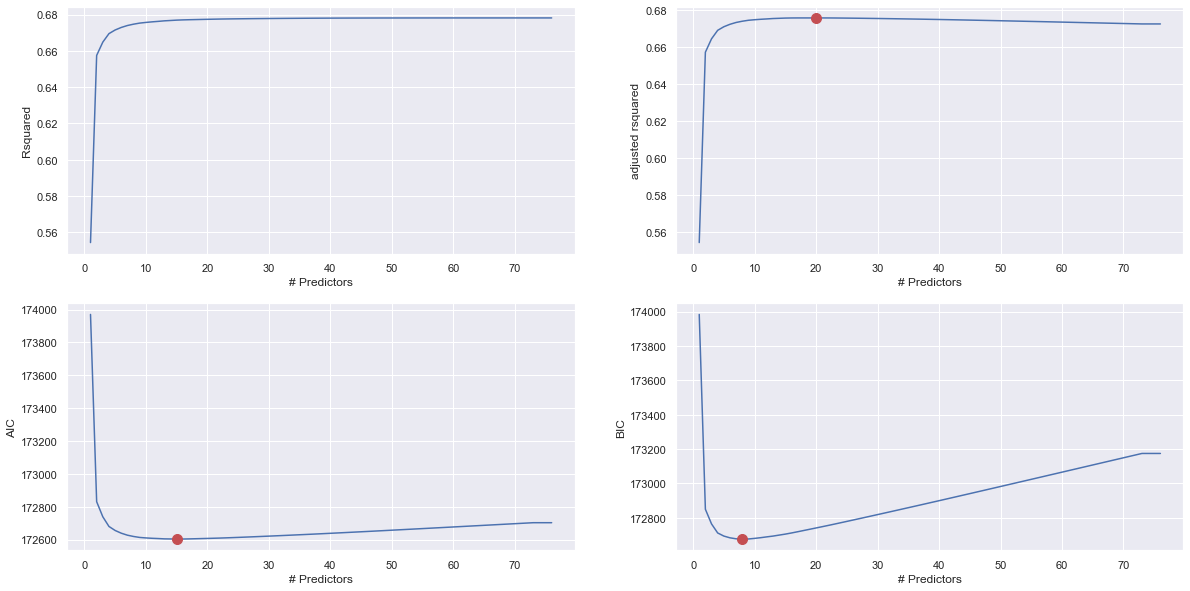

In [22]:
best_sub_plots()


In [23]:
best_fwd_reg_model1 = models_best['model'][9]
best_fwd_reg_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     999.9
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:29:16   Log-Likelihood:                -86296.
No. Observations:                4337   AIC:                         1.726e+05
Df Residuals:                    4327   BIC:                         1.727e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.072e+07   3.46e+06     -8.871      0.000   -3.75e+07   -2.39e+07
budget          2.4814      0.047     52.731      0.000       2.389       2.574
votes         377.1799     10.068     37.462      0.000     357.441     396.919
Animation    7.328e+07   7.71e+06      9.505      0.000    5.82e+07    8.84e+07
Family       4.812e+08   6.13e+07      7.846      0.000    3.61e+08    6.01e+08
R           -1.712e+07   3.48e+06     -4.915      0.000   -2.39e+07   -1.03e+07
Horror        3.76e+07   7.84e+06      4.793      0.000    2.22e+07     5.3e+07
Comedy        1.42e+07   3.77e+06      3.765      0.000    6.81e+06    2.16e+07
Germany     -3.915e+07   1.25e+07     -3.121      0.002   -6.37e+07   -1.46e+07
New_Zealand   7.27e+07    2.6e+07      2.801      0.005    2.18e+07    1.24e+08
==============================================================================
Omnibus:                     3398.856   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           250024.892
Skew:                           3.168   Prob(JB):                         0.00
Kurtosis:                      39.653   Cond. No.                     2.09e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
best_fwd_reg_model2 = models_best['model'][8]
best_fwd_reg_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     1122.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:29:30   Log-Likelihood:                -86300.
No. Observations:                4337   AIC:                         1.726e+05
Df Residuals:                    4328   BIC:                         1.727e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.065e+07   3.47e+06     -8.844      0.000   -3.74e+07   -2.39e+07
budget         2.4806      0.047     52.674      0.000       2.388       2.573
votes        380.0473     10.024     37.914      0.000     360.395     399.699
Animation   7.282e+07   7.71e+06      9.440      0.000    5.77e+07    8.79e+07
Family      4.805e+08   6.14e+07      7.829      0.000     3.6e+08    6.01e+08
R          -1.719e+07   3.49e+06     -4.932      0.000    -2.4e+07   -1.04e+07
Horror      3.737e+07   7.85e+06      4.761      0.000     2.2e+07    5.28e+07
Comedy      1.416e+07   3.78e+06      3.751      0.000    6.76e+06    2.16e+07
Germany    -3.947e+07   1.26e+07     -3.144      0.002   -6.41e+07   -1.49e+07
==============================================================================
Omnibus:                     3374.784   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           246036.408
Skew:                           3.134   Prob(JB):                         0.00
Kurtosis:                      39.362   Cond. No.                     2.09e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
#Finding the RMSE of the model selected using the forward selection procedure, where the predictors
#include 2-factor interactions
pred_gross = best_fwd_reg_model1.predict(test)
np.sqrt(((pred_gross - test.gross)**2).mean())

117156846.16279814

## BACKWARD STEPWISE SELECTION

In [34]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [35]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [36]:
models_best = backward_selection()

Processed  76 models on 75 predictors in 21.145810842514038 seconds.
Processed  75 models on 74 predictors in 32.93132996559143 seconds.
Processed  74 models on 73 predictors in 25.15191102027893 seconds.
Processed  73 models on 72 predictors in 29.35405397415161 seconds.
Processed  72 models on 71 predictors in 56.605204820632935 seconds.
Processed  71 models on 70 predictors in 24.737207174301147 seconds.
Processed  70 models on 69 predictors in 18.838034868240356 seconds.
Processed  69 models on 68 predictors in 14.444785833358765 seconds.
Processed  68 models on 67 predictors in 14.704560041427612 seconds.
Processed  67 models on 66 predictors in 8.012302875518799 seconds.
Processed  66 models on 65 predictors in 8.126534938812256 seconds.
Processed  65 models on 64 predictors in 7.677777290344238 seconds.
Processed  64 models on 63 predictors in 8.099999904632568 seconds.
Processed  63 models on 62 predictors in 8.866546869277954 seconds.
Processed  62 models on 61 predictors in 1

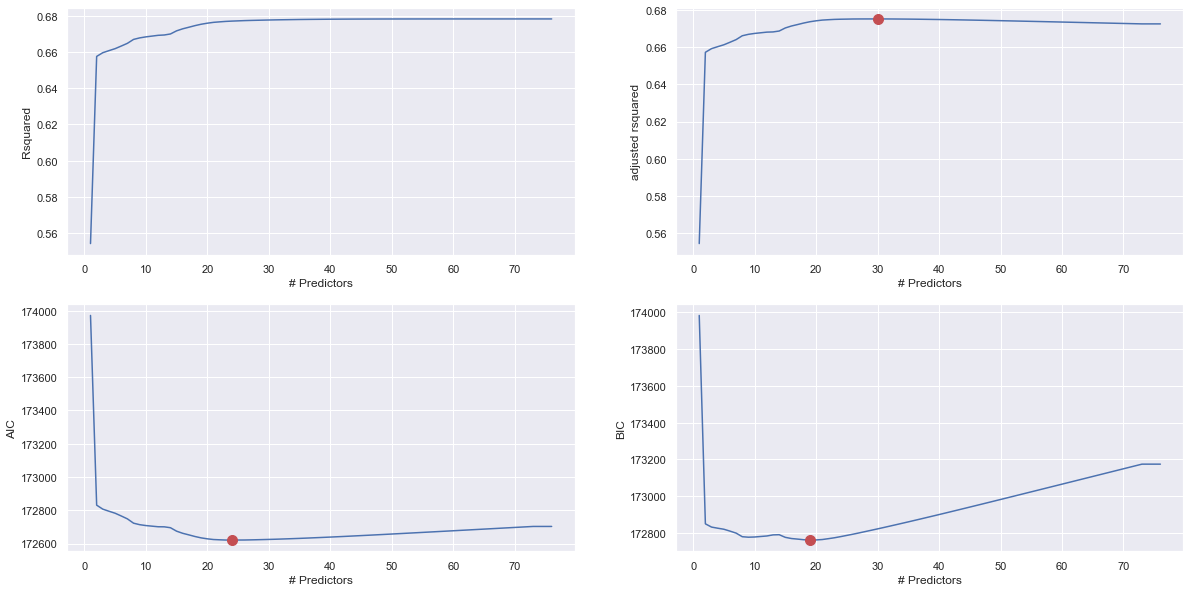

In [37]:
best_sub_plots()

In [38]:
best_bwd_reg_model3 = models_best['model'][19]
best_bwd_reg_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     472.4
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:57:17   Log-Likelihood:                -86297.
No. Observations:                4337   AIC:                         1.726e+05
Df Residuals:                    4317   BIC:                         1.728e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.275e+08   6.16e+07      6.939      0.000    3.07e+08    5.48e+08
votes        381.1975     10.065     37.872      0.000     361.464     400.931
budget         2.4898      0.050     49.774      0.000       2.392       2.588
Germany    -4.003e+07   1.26e+07     -3.185      0.001   -6.47e+07   -1.54e+07
Comedy     -4.604e+08   6.16e+07     -7.477      0.000   -5.81e+08    -3.4e+08
Action     -4.763e+08   6.16e+07     -7.735      0.000   -5.97e+08   -3.56e+08
Drama      -4.713e+08   6.17e+07     -7.644      0.000   -5.92e+08    -3.5e+08
Biography  -4.818e+08   6.19e+07     -7.788      0.000   -6.03e+08   -3.61e+08
Horror      -4.37e+08    6.2e+07     -7.047      0.000   -5.59e+08   -3.15e+08
Adventure  -4.687e+08   6.18e+07     -7.591      0.000    -5.9e+08   -3.48e+08
Crime      -4.771e+08   6.18e+07     -7.716      0.000   -5.98e+08   -3.56e+08
Animation  -4.007e+08   6.18e+07     -6.484      0.000   -5.22e+08    -2.8e+08
Fantasy    -4.553e+08   6.46e+07     -7.045      0.000   -5.82e+08   -3.29e+08
Thriller   -4.378e+08   7.53e+07     -5.816      0.000   -5.85e+08    -2.9e+08
Mystery    -4.668e+08   6.88e+07     -6.789      0.000   -6.02e+08   -3.32e+08
Sci_Fi     -5.017e+08   7.53e+07     -6.666      0.000   -6.49e+08   -3.54e+08
Romance    -4.891e+08   8.12e+07     -6.024      0.000   -6.48e+08    -3.3e+08
Western    -4.752e+08   1.23e+08     -3.873      0.000   -7.16e+08   -2.35e+08
PG_13       1.306e+07   3.93e+06      3.327      0.001    5.37e+06    2.08e+07
PG          2.152e+07   5.06e+06      4.254      0.000    1.16e+07    3.14e+07
==============================================================================
Omnibus:                     3368.475   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           247002.145
Skew:                           3.122   Prob(JB):                         0.00
Kurtosis:                      39.440   Cond. No.                     8.21e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.21e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
best_fwd_reg_model4 = models_best['model'][18]
best_fwd_reg_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     497.0
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:57:42   Log-Likelihood:                -86302.
No. Observations:                4337   AIC:                         1.726e+05
Df Residuals:                    4318   BIC:                         1.728e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.273e+08   6.17e+07      6.929      0.000    3.06e+08    5.48e+08
votes        381.4814     10.076     37.862      0.000     361.728     401.235
budget         2.4850      0.050     49.648      0.000       2.387       2.583
Comedy      -4.61e+08   6.16e+07     -7.480      0.000   -5.82e+08    -3.4e+08
Action     -4.767e+08   6.16e+07     -7.733      0.000   -5.98e+08   -3.56e+08
Drama      -4.722e+08   6.17e+07     -7.650      0.000   -5.93e+08   -3.51e+08
Biography  -4.829e+08   6.19e+07     -7.798      0.000   -6.04e+08   -3.61e+08
Horror     -4.369e+08   6.21e+07     -7.037      0.000   -5.59e+08   -3.15e+08
Adventure  -4.699e+08   6.18e+07     -7.602      0.000   -5.91e+08   -3.49e+08
Crime      -4.777e+08   6.19e+07     -7.717      0.000   -5.99e+08   -3.56e+08
Animation  -4.007e+08   6.19e+07     -6.477      0.000   -5.22e+08   -2.79e+08
Fantasy    -4.552e+08   6.47e+07     -7.036      0.000   -5.82e+08   -3.28e+08
Thriller   -4.379e+08   7.54e+07     -5.811      0.000   -5.86e+08    -2.9e+08
Mystery    -4.666e+08   6.88e+07     -6.779      0.000   -6.02e+08   -3.32e+08
Sci_Fi     -5.017e+08   7.53e+07     -6.659      0.000   -6.49e+08   -3.54e+08
Romance    -4.892e+08   8.13e+07     -6.019      0.000   -6.49e+08    -3.3e+08
Western    -4.754e+08   1.23e+08     -3.870      0.000   -7.16e+08   -2.35e+08
PG_13       1.349e+07   3.93e+06      3.434      0.001    5.79e+06    2.12e+07
PG          2.191e+07   5.06e+06      4.327      0.000     1.2e+07    3.18e+07
==============================================================================
Omnibus:                     3365.937   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           247647.678
Skew:                           3.117   Prob(JB):                         0.00
Kurtosis:                      39.491   Cond. No.                     8.21e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.21e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
#Finding the RMSE of the model selected using the forward selection procedure, where the predictors
#include 2-factor interactions
pred_gross = best_fwd_reg_model3.predict(test)
np.sqrt(((pred_gross - test.gross)**2).mean())

# this doesn't run cuz the test data does not have a movie of the "Sci_Fi" genre in it

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'Sci_Fi' is not defined
    gross~votes+budget+Germany+Comedy+Action+Drama+Biography+Horror+Adventure+Crime+Animation+Fantasy+Thriller+Mystery+Sci_Fi+Romance+Western+PG_13+PG
                                                                                                                       ^^^^^^

In [44]:
test.columns

Index(['name', 'year', 'released', 'score', 'votes', 'director', 'writer',
       'star', 'budget', 'gross', 'company', 'runtime', 'G', 'NC_17',
       'Not_Rated', 'PG', 'PG_13', 'R', 'TV_MA', 'Unrated', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Thriller',
       'Western', 'Argentina', 'Australia', 'Belgium', 'Brazil', 'Canada',
       'China', 'Colombia', 'Czech_Republic', 'Denmark', 'France', 'Germany',
       'Hong_Kong', 'India', 'Indonesia', 'Ireland', 'Italy', 'Japan', 'Malta',
       'Mexico', 'Netherlands', 'New_Zealand', 'Norway', 'Portugal', 'Russia',
       'South_Africa', 'South_Korea', 'Spain', 'Sweden', 'Taiwan', 'Thailand',
       'United_Kingdom', 'United_States'],
      dtype='object')

In [45]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

## RIDGE - was not successful - disregard

In [46]:
y = train.gross

In [47]:
#Standardizing predictors so that each of them have zero mean and unit variance

# Dropping `United_States`, `Action`, and `PG_13` predictors to avoid multicollinearity
X = train.loc[:,['year','score','votes','budget','runtime','United_States', 'United_Kingdom', 'France', 'Germany', 'Belgium',
       'Spain', 'Japan', 'Australia', 'New_Zealand', 'China', 'Canada',
       'Austria', 'Norway', 'Iceland', 'West_Germany', 'Mexico',
       'Ireland', 'Italy', 'South_Korea', 'Hong_Kong', 'India',
       'United_Arab_Emirates', 'Czech_Republic', 'Finland', 'Taiwan',
       'Lebanon', 'South_Africa', 'Argentina', 'Indonesia', 'Iran',
       'Switzerland', 'Brazil', 'Republic_of_Macedonia', 'Sweden',
       'Russia', 'Netherlands', 'Aruba', 'Jamaica', 'Chile', 'Panama',
       'Denmark', 'Israel', 'Federal_Republic_of_Yugoslavia', 'Kenya',
       'Yugoslavia', 'Hungary','Comedy', 'Action', 'Drama', 'Biography', 'Horror', 'Adventure',
       'Crime', 'Animation', 'Fantasy', 'Thriller', 'Mystery', 'Sci_Fi',
       'Family', 'Romance', 'Western','PG_13', 'R', 'PG', 'Not_Rated', 'G', 'Unrated', 'X', 'NC_17',
       'Approved', 'TV_MA']]

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

In [48]:
#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

In [49]:
#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)

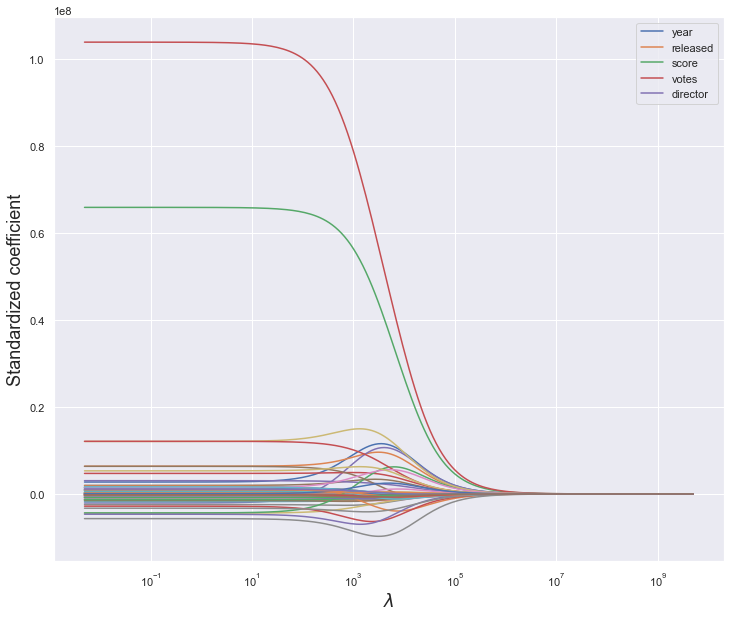

In [50]:
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

In [51]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
ridgecv.alpha_

/Users/aarti.pappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


15.811388300841896

Text(0, 0.5, 'Cross-validation error')

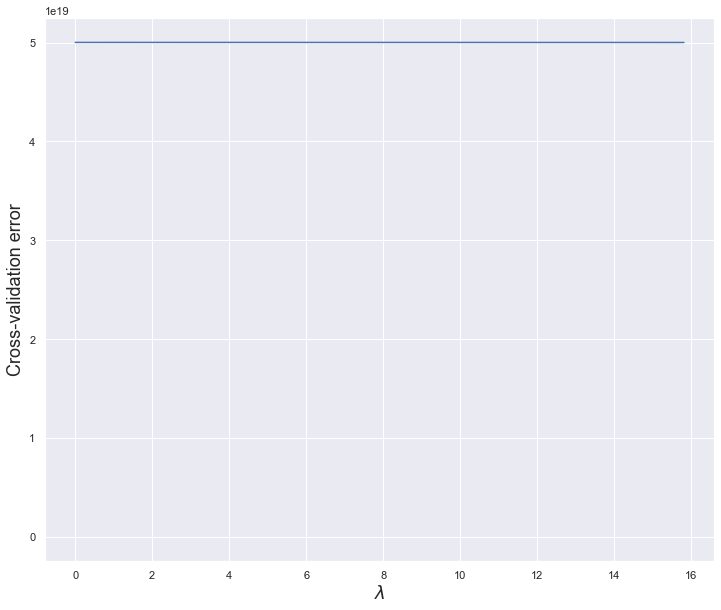

In [52]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

## LASSO - was not successful - disregard

In [54]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

In [55]:
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

/Users/aarti.pappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e+17, tolerance: 1.500e+16
  model = cd_fast.enet_coordinate_descent(
/Users/aarti.pappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.110e+17, tolerance: 1.500e+16
  model = cd_fast.enet_coordinate_descent(
/Users/aarti.pappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

KeyboardInterrupt: 

In [ ]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

In [ ]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

In [ ]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')